In [1]:
using RxInfer, Distributions, LinearAlgebra

In [5]:

n_samples = 100
n_arms    = 2
n_contexts  = 2
context_dim = 2
arms     = [[1.0, 2.5], [-0.5, 2.0]] # True arm parameters
contexts = [[-0.5, 1.0], [0.5, 1.0]] # Context feature vectors
arm_choices     = []
context_choices = []
rewards         = []

# Noise standard deviation (matches model's assumed precision = 1.0 -> variance = 1.0 -> sd = 1.0)
noise_sd = 1.0

for i in 1:n_samples
    push!(context_choices, rand(1:n_contexts))
    push!(arm_choices, rand(1:n_arms))
    # Calculate the deterministic part of the reward
    mean_reward = arms[arm_choices[end]]' * contexts[context_choices[end]]
    # Add Gaussian noise
    noisy_reward = mean_reward + randn() * noise_sd
    push!(rewards, noisy_reward)
end

# Convert to the required types for the model
rewards_data = Float64.(rewards)
contexts_data = Vector{Float64}[contexts[idx] for idx in context_choices]
arm_choices_data = Int.(arm_choices);

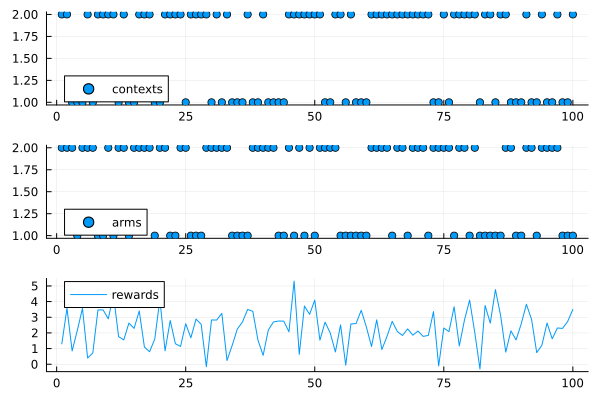

In [6]:
using Plots

p1 = scatter(context_choices, label="contexts")
p2 = scatter(arm_choices, label="arms")
p3 = plot(rewards, label="rewards")

plot(p1, p2, p3, layout=(3, 1))

In [7]:
@model function contextual_bandit(n_arms, priors, past_rewards, goal_reward, past_choices, past_contexts, current_context)
    local θ
    local γ
    
    # Prior for each arm's parameters
    for k in 1:n_arms
        θ[k] ~ priors[:θ][k]
        γ[k] ~ Wishart(3, diagm(ones(context_dim)))
    end
        
    # Model for past observations
    for n in eachindex(past_rewards)
        arm[n] ~ NormalMixture(switch = past_choices[n], m = θ, p = γ)
        # Set γ=1.0 to match the data generation variance
        past_rewards[n] ~ Normal(μ=dot(arm[n], past_contexts[n]), γ=1.0)
    end

    # Model for current decision
    s ~ priors[:s]
    z ~ Categorical(s)
    current_arm ~ NormalMixture(switch = z, m = θ, p = γ)
    # Set γ=1.0 to match the data generation variance
    goal_reward ~ Normal(μ=dot(current_arm, current_context), γ=1.0)
end

In [12]:
@model function contextual_bandit_simplified(n_arms, priors, past_rewards, past_choices, past_contexts)
    local θ
    local γ
    local τ
    
    τ ~ priors[:τ]
    # Prior for each arm's parameters
    for k in 1:n_arms
        θ[k] ~ priors[:θ][k]
        γ[k] ~ Wishart(3, diagm(ones(context_dim)))
    end
        
    # Model for past observations
    for n in eachindex(past_rewards)
        arm[n] ~ NormalMixture(switch = past_choices[n], m = θ, p = γ)
        # Set γ=1.0 to match the data generation variance
        past_rewards[n] ~ Normal(μ=dot(arm[n], past_contexts[n]), γ=τ)
    end
end

In [32]:
priors = Dict(:θ => [MvNormal([0.0, 0.0], diagm(ones(2))), MvNormal([1.0, 1.0], diagm(ones(2)))], :τ => GammaShapeRate(1.0, 1.0))
init = @initialization begin
    q(θ) = priors[:θ]
    q(γ) = Wishart(3, diagm(ones(context_dim)))
    q(τ) = GammaShapeRate(1.0, 1.0)
end

results = infer(
    model = contextual_bandit_simplified(
        n_arms = n_arms, 
        priors = priors,
    ), 
    data  = (past_rewards = rewards, past_choices=[arm_choices[i] == 1 ? [0.0, 1.0] : [1.0, 0.0] for i in arm_choices], past_contexts=[contexts[i] for i in context_choices]), 
    constraints   = MeanField(),
    initialization = init, 
    iterations  = 50, 
    free_energy = true
) 

Inference results:
  Posteriors       | available for (γ, arm, τ, θ)
  Free Energy:     | Real[243.526, 225.116, 220.108, 215.206, 210.367, 205.635, 201.065, 196.715, 192.642, 188.904  …  170.443, 170.433, 170.424, 170.416, 170.408, 170.401, 170.394, 170.388, 170.383, 170.377]


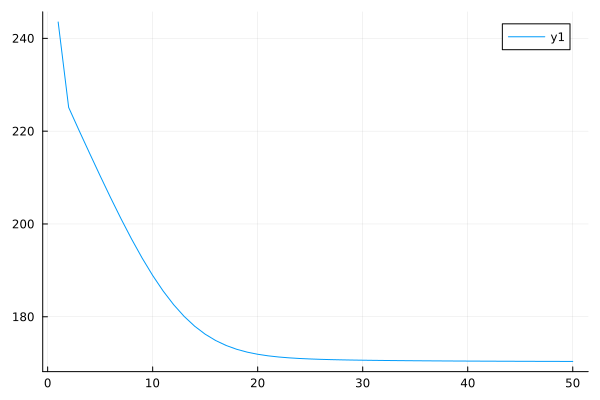

In [33]:
plot(results.free_energy)

In [34]:
mean.(results.posteriors[:θ][end])

2-element Vector{Vector{Float64}}:
 [0.041020480517061704, 2.2193240583332283]
 [0.9999999997128022, 1.0000000003680778]

In [35]:
mean.(results.posteriors[:θ][end])[2]'*contexts[2]

1.5000000002244789

In [36]:
arms

2-element Vector{Vector{Float64}}:
 [1.0, 2.5]
 [-0.5, 2.0]

In [37]:
arms[2]'*contexts[2]

1.75

In [47]:
# n_epochs = 500
# window_length = 100
# historical_choices = [[[0.0, 1.0], [1.0, 0.0]][i] for i in arm_choices]
# historical_contexts_num = context_choices
# historical_contexts = [contexts[i] for i in historical_contexts_num]
# historical_rewards = deepcopy(rewards)
# baseline_rewards = deepcopy(rewards)
# posteriors = Dict(:θ => [MvNormal([-1.0, -1.0], 1e2diagm(ones(2))), MvNormal([1.0, 1.0], 1e2diagm(ones(2)))], :s => Dirichlet(ones(n_arms)))

# for epoch in 1:n_epochs
#     priors = Dict(:θ => posteriors[:θ], :s => posteriors[:s])
#     init = @initialization begin
#         q(s) = posteriors[:s]
#         q(θ) = priors[:θ]
#         q(γ) = Wishart(3, diagm(ones(context_dim)))
#         q(current_arm) = vague(MvNormalMeanPrecision, 2)
#     end

#     current_context_num = rand(1:n_contexts)

#     results = infer(
#         model = contextual_bandit(
#             n_arms = n_arms, 
#             priors = priors,
#         ), 
#         data  = (past_rewards = historical_rewards[end-window_length+1:end], goal_reward=1e3, past_choices=historical_choices[end-window_length+1:end], past_contexts=historical_contexts[end-window_length+1:end], current_context=contexts[current_context_num]), 
#         constraints   = MeanField(),
#         initialization = init, 
#         iterations  = 50, 
#         free_energy = true
#     )

#     push!(historical_contexts, contexts[current_context_num]) 
    
#     # FIXED: Proper Thompson Sampling implementation
#     # Sample from each arm's posterior and choose the arm with highest expected reward
#     sampled_rewards = zeros(n_arms)
#     for k in 1:n_arms
#         # Sample parameters for arm k
#         theta_sample = rand(results.posteriors[:θ][end][k])
#         # Calculate expected reward for current context
#         sampled_rewards[k] = dot(theta_sample, contexts[current_context_num])
#     end
    
#     # Choose the best arm based on sampled parameters
#     chosen_arm = argmax(sampled_rewards)
    
#     # Create one-hot encoding
#     arm_to_choose = zeros(n_arms)
#     arm_to_choose[chosen_arm] = 1.0
    
#     push!(historical_choices, arm_to_choose)
#     posteriors[:θ] = results.posteriors[:θ][end]
#     posteriors[:s] = results.posteriors[:s][end]
    
#     # Get reward with noise (consistent with the training data)
#     noise = randn() * noise_sd
#     push!(historical_rewards, arms[chosen_arm]'contexts[current_context_num] + noise)
    
#     # For baseline, randomly choose an arm and get its reward
#     random_arm = rand(1:n_arms)
#     random_noise = randn() * noise_sd
#     push!(baseline_rewards, arms[random_arm]'contexts[current_context_num] + random_noise)
    
#     push!(historical_contexts_num, current_context_num)
# end

In [59]:
n_epochs = 500
window_length = 100
historical_choices_idx = deepcopy(arm_choices)  # Store actual indices, not one-hot
historical_contexts_num = context_choices
historical_contexts = [contexts[i] for i in historical_contexts_num]
historical_rewards = deepcopy(rewards)
baseline_rewards = deepcopy(rewards)

# Initialize posteriors with reasonable priors
posteriors = Dict(
    :θ => [MvNormal(zeros(2), diagm(ones(2))) for _ in 1:n_arms]
)

for epoch in 1:n_epochs
    priors = Dict(:θ => posteriors[:θ])
    
    # Default initialization
    init = @initialization begin
        q(θ) = priors[:θ]
    end
    
    current_context_num = rand(1:n_contexts)
    current_context = contexts[current_context_num]
    
    # Use only last window_length observations
    data_idx = max(1, length(historical_rewards) - window_length + 1):length(historical_rewards)

    # Run inference with simplified model
    results = infer(
        model = contextual_bandit_simplified(
            n_arms = n_arms, 
            priors = priors,
        ), 
        data = (
            past_rewards = historical_rewards[data_idx], 
            past_choices_idx = historical_choices_idx[data_idx],
            past_contexts = historical_contexts[data_idx], 
            current_context = current_context
        ), 
        constraints = MeanField(),
        initialization = init,
        iterations = 50, 
        free_energy = true
    )
    
    # Thompson Sampling: Sample parameter vectors and choose best arm
    expected_rewards = zeros(n_arms)
    for k in 1:n_arms
        # Sample parameters from posterior
        theta_sample = rand(results.posteriors[:θ][end][k])
        expected_rewards[k] = dot(theta_sample, current_context)
    end
    
    # Choose best arm based on sampled parameters
    chosen_arm = argmax(expected_rewards)
    
    # Track history
    push!(historical_contexts, current_context)
    push!(historical_contexts_num, current_context_num)
    push!(historical_choices_idx, chosen_arm)
    
    # Update posteriors for next iteration
    posteriors[:θ] = results.posteriors[:θ][end]
    
    # Get reward with noise
    reward = dot(arms[chosen_arm], current_context) + randn() * noise_sd
    push!(historical_rewards, reward)
    
    # Random baseline
    random_arm = rand(1:n_arms)
    baseline_reward = dot(arms[random_arm], current_context) + randn() * noise_sd
    push!(baseline_rewards, baseline_reward)
end

┌ Warning: `data` object has `past_choices_idx` specification, but model has no data input named `past_choices_idx`. Use `warn = false` to suppress this warning.
└ @ RxInfer /Users/apodusenko/.julia/dev/RxInfer/src/inference/batch.jl:294
┌ Warning: `data` object has `current_context` specification, but model has no data input named `current_context`. Use `warn = false` to suppress this warning.
└ @ RxInfer /Users/apodusenko/.julia/dev/RxInfer/src/inference/batch.jl:294
┌ Warning: `data` object has `past_choices_idx` specification, but model has no data input named `past_choices_idx`. Use `warn = false` to suppress this warning.
└ @ RxInfer /Users/apodusenko/.julia/dev/RxInfer/src/inference/batch.jl:294
┌ Warning: `data` object has `current_context` specification, but model has no data input named `current_context`. Use `warn = false` to suppress this warning.
└ @ RxInfer /Users/apodusenko/.julia/dev/RxInfer/src/inference/batch.jl:294
┌ Warning: `data` object has `past_choices_idx` spec

ErrorException: Half-edge has been found: θ_3. To terminate half-edges 'Uninformative' node can be used.

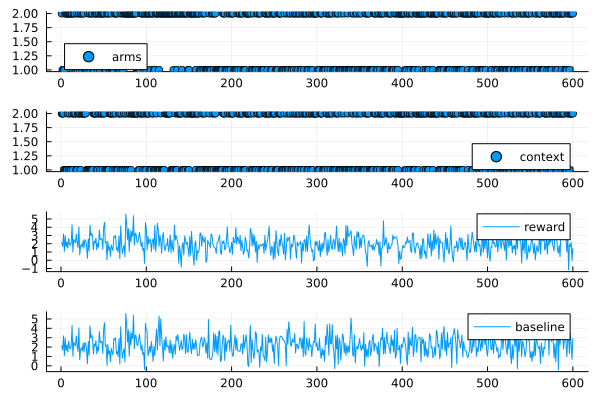

In [50]:
p1 = scatter(argmax.(historical_choices), label="arms")
p2 = scatter(historical_contexts_num, label="context")
p3 = plot(historical_rewards, label="reward")
p4 = plot(baseline_rewards, label="baseline")
plot(p1, p2, p3, p4, layout=(4, 1))

In [51]:
sum(historical_rewards)

1178.7721423291932

In [52]:
sum(baseline_rewards)

1328.4988182915986